In [1]:
import numpy as np 
import pandas as pd 
import torch
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import evaluate, train_and_eval, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'zh'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 
DEC_DROPOUT = 0  
ATTENTION_TYPE = 'without'

# training params  
NUM_EPOCHS = 10 
LR = 0.00015 
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
if NETWORK_TYPE == 'rnn': 
    EXPERIMENT_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    EXPERIMENT_NAME = '{}-cnn'.format(SRC_LANG)
MODEL_NAME = '{}-{}'.format(EXPERIMENT_NAME, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [8]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [9]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
    lazy_eval=True, print_attn=False, inspect_samples=3)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.17, Train BLEU: 0.00, Val BLEU: 0.77, Minutes Elapsed: 0.12
Sampling from val predictions...
Source: 地球 上 总共 共有 一万 <UNK> 万种 种鸟 鸟类 <EOS>
Reference: there are 10,000 species of birds in the world
Model: <SOS> &apos;re the the the the the the the the

Source: 这 是 个 很 悲惨 的 事实 那 就是 朝鲜
Reference: it &apos;s tragic that north koreans have to hide
Model: <SOS> we the the the the the the the the

Source: 讲话 会 变得 <UNK> 而且 之后 伴随 更多 气息 音
Reference: the speech actually becomes quieter and more <UNK> after
Model: <SOS> we the the the the the the the ,



Epoch: 0.15, Train Loss: 0.00, Val Loss: 6.08, Train BLEU: 0.00, Val BLEU: 2.95, Minutes Elapsed: 11.52
Sampling from val predictions...
Source: 我 没有 一天 不想 这些 美丽 但 却 受到 不公
Reference: there is not a day that goes by that
Model: <SOS> and &apos;s , , , , , , ,

Source: 我们 做 过 调查 对 世界 上 100 家 标杆
Reference: we &apos;ve done the research , and we have
Model: <SOS> and , , , , , , , ,

Source: 他 不 愿意 像 其他 婴儿 那样 玩儿 实际 实际上
Reference: he didn &apos;t want to play like the other
Model: <SOS> and &apos;s , , , , , , ,



Epoch: 0.30, Train Loss: 0.00, Val Loss: 6.00, Train BLEU: 0.00, Val BLEU: 3.86, Minutes Elapsed: 22.74
Sampling from val predictions...
Source: 他 很 害怕 会 掉 到 水里 <EOS> <PAD> <PAD>
Reference: he was petrified he would be knocked in the
Model: <SOS> it &apos;s a a . . . <EOS> <EOS>

Source: 公共 空间 可以 更好 的 体现 到底 什么 对 我们
Reference: our shared spaces can better reflect what matters to
Model: <SOS> and , , , the the the . the

Source: 所以 他们 又 跳进 <UNK> 进来 杀死 了 动物 <EOS>
Reference: so he jumps in and kills the animals .
Model: <SOS> it &apos;s a , the . . . .



Epoch: 0.45, Train Loss: 0.00, Val Loss: 5.85, Train BLEU: 0.00, Val BLEU: 2.95, Minutes Elapsed: 34.03
Sampling from val predictions...
Source: 而且 参议 参议院 议院 担心 的 另 一件 事 这个
Reference: and also , the senate &apos;s other worry ,
Model: <SOS> and , we , we , the , ,

Source: 帮助 幸存 幸存者 重新 找回 美好 可爱 的 自己 重新
Reference: recast survivors as wonderful , lovable people with full
Model: <SOS> and , the the , the , the the

Source: 但 很多 人 不 这么 认为 <EOS> <PAD> <PAD> <PAD>
Reference: but most people don &apos;t agree . <EOS> <PAD>
Model: <SOS> i &apos;s &apos;s , a to to . .



Epoch: 0.60, Train Loss: 0.00, Val Loss: 5.74, Train BLEU: 0.00, Val BLEU: 2.08, Minutes Elapsed: 45.39
Sampling from val predictions...
Source: 内罗毕 国家 公园 的 南部 并 没有 全部 围起 栅栏
Reference: nairobi national park is not <UNK> in the south
Model: <SOS> and , : , , , , , ,

Source: 我们 必须 创造 一个 全新 的 职业 <EOS> <PAD> <PAD>
Reference: you have to create a new profession . <EOS>
Model: <SOS> we we to to to . . . <EOS>

Source: 第二 第二件 二件 事 你 可以 了解 到 当 美国
Reference: second thing you can learn is that when a
Model: <SOS> and , , , , to , , ,



Epoch: 0.75, Train Loss: 0.00, Val Loss: 5.65, Train BLEU: 0.00, Val BLEU: 4.42, Minutes Elapsed: 56.80
Sampling from val predictions...
Source: 以上 这些 就是 我 觉得 能够 帮助 我们 大家 打开
Reference: so i think these are just a few keys
Model: <SOS> and , , to , , , , ,

Source: 而且 仅仅 几年 年后 我们 有 了 第一 第一次 一次
Reference: and it was only a few years later that
Model: <SOS> and , , the to , , , ,

Source: 自己 种 食物 就 好像 自己 印 钱 似的 <EOS>
Reference: growing your own food is like printing your own
Model: <SOS> and , , , , <EOS> . . <EOS>



Epoch: 0.90, Train Loss: 0.00, Val Loss: 5.53, Train BLEU: 0.00, Val BLEU: 3.36, Minutes Elapsed: 68.23
Sampling from val predictions...
Source: 如果 孩子 们 种植 <UNK> 孩子 们 就 会 吃
Reference: if kids grow <UNK> , kids eat <UNK> .
Model: <SOS> and , have to to , , to the

Source: 但 我们 还是 会 得到 大量 来自 不同 环境 下
Reference: but we &apos;ll get a very large sample of
Model: <SOS> but we we to to to of of of

Source: 我 确实 实有 太多 从没 机会 穿 的 8 英寸
Reference: i do have too many <UNK> heels which i
Model: <SOS> i can to to to , , , the



Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.46, Train BLEU: 0.00, Val BLEU: 4.85, Minutes Elapsed: 75.97
Sampling from val predictions...
Source: 我 都 快 抓狂 了 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: and i was distraught . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i i &apos;m , . <EOS> <EOS> . <EOS>

Source: 警报 拉 响 的 时候 他 不得 不得不 冲向 向海
Reference: he had to go towards the water as the
Model: <SOS> and , , , the the , of and

Source: 在 这里 工作 的 人 通常 都 要 忍受 客人
Reference: the workers here often endure tragic sexual abuse at
Model: <SOS> and the of the the the the the ,



Epoch: 1.15, Train Loss: 0.00, Val Loss: 5.44, Train BLEU: 0.00, Val BLEU: 4.56, Minutes Elapsed: 87.44
Sampling from val predictions...
Source: 但 同时 我 又 很 开心 并 受 尊重 的
Reference: but i &apos;m also happy and honored to be
Model: <SOS> but i i to to to , , ,

Source: 整个 过程 非常 费时 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: it was very time-consuming . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> and &apos;s a . . . . . <EOS>

Source: 那 就是 <UNK> 听 他们 说 <EOS> <PAD> <PAD> <PAD>
Reference: i shut up , and listen to them .
Model: <SOS> it &apos;s &apos;t the the . . <EOS> .



Epoch: 1.30, Train Loss: 0.00, Val Loss: 5.39, Train BLEU: 0.00, Val BLEU: 5.19, Minutes Elapsed: 98.96
Sampling from val predictions...
Source: 这 并 不是 说 母亲 们 对于 我们 的 成功
Reference: it &apos;s not to say that our mothers aren
Model: <SOS> and &apos;s a to to to &quot; we .

Source: 你 的 钱 可能 被 偷 你 可能 因 战争
Reference: your money can be stolen . you can be
Model: <SOS> you you , your your you you you ,

Source: 这 就是 我 和 那些 学生 们 对话 时 的
Reference: that &apos;s just how i felt as i had
Model: <SOS> and &apos;s what i i i to to i



Epoch: 1.45, Train Loss: 0.00, Val Loss: 5.34, Train BLEU: 0.00, Val BLEU: 5.27, Minutes Elapsed: 110.44
Sampling from val predictions...
Source: 那 就是 她 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: there she is . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> that &apos;s a . . . . <EOS> <EOS>

Source: 在 50 <UNK> 摄氏 摄氏度 的 高温 中 男人 女人
Reference: enveloped in temperatures of 130 degrees , men ,
Model: <SOS> in <UNK> , , , , , the ,

Source: 我 的 父亲 那 就是 他 他 是 他家 家族
Reference: and my father -- that &apos;s him -- he
Model: <SOS> i i was was , was was i ,



Epoch: 1.60, Train Loss: 0.00, Val Loss: 5.29, Train BLEU: 0.00, Val BLEU: 4.34, Minutes Elapsed: 121.53
Sampling from val predictions...
Source: 当 摄影 摄影师 要 我 <UNK> 背 摸 那个 男士
Reference: i was totally uncomfortable , and the photographer was
Model: <SOS> when when , to , , i i ,

Source: 现在 我 所讲 讲述 的 这个 疯狂 爱情 的 故事
Reference: i &apos;m here to tell you the story of
Model: <SOS> now i to to to a the , of

Source: 但 令人 <UNK> 的 是 帕金森 帕金森症 和 其他 运动
Reference: but <UNK> , with parkinson &apos;s disease and other
Model: <SOS> but the <UNK> <UNK> , , , , <EOS>



Epoch: 1.75, Train Loss: 0.00, Val Loss: 5.27, Train BLEU: 0.00, Val BLEU: 5.51, Minutes Elapsed: 132.74
Sampling from val predictions...
Source: 因为 我 的 家人 不 懂 中文 所以 我 得
Reference: since my family couldn &apos;t speak chinese , i
Model: <SOS> because , i , , to to , i

Source: 可以 想一想 小孩 学说 <UNK> 说话 得 花 多长 多长时间
Reference: i mean , just think how long it takes
Model: <SOS> and , &apos;t it &apos;s , &apos;s is is

Source: 我 永远 不会 忘记 那个 早晨 <EOS> <PAD> <PAD> <PAD>
Reference: a morning that i will never forget . <EOS>
Model: <SOS> i i of i was to . <EOS> <EOS>



Epoch: 1.90, Train Loss: 0.00, Val Loss: 5.21, Train BLEU: 0.00, Val BLEU: 5.04, Minutes Elapsed: 144.00
Sampling from val predictions...
Source: 汞 是 用来 提取 金子 的 <EOS> <PAD> <PAD> <PAD>
Reference: mercury is used in the extraction process . <EOS>
Model: <SOS> it &apos;s a a the . . . <EOS>

Source: 我 想 这 就是 内罗毕 公园 的 狮子 <UNK> 子会
Reference: and i think this is why the nairobi national
Model: <SOS> i i think this &apos;s a a the of

Source: 今天 早上 给 这次 大会 <UNK> 开幕 <UNK> 的 先生
Reference: this morning , the gentleman who opened this conference
Model: <SOS> and , is the , of the the the



Epoch: 2.00, Train Loss: 0.00, Val Loss: 5.21, Train BLEU: 0.00, Val BLEU: 5.70, Minutes Elapsed: 151.61
Sampling from val predictions...
Source: 每当 有人 打喷嚏 喷嚏 时 我 都 感觉 新奥尔良 奥尔良
Reference: i feel like every time someone <UNK> , new
Model: <SOS> and course &apos;t , , of i a i

Source: 没人 能 独自 自创 创立 一个 企业 没人 <EOS> <PAD>
Reference: nobody started a company alone . no one .
Model: <SOS> the : &apos;t the of the the &apos;s the

Source: 举例 举例来说 来说 一直 直到 <UNK> 年 英国 <UNK> <UNK>
Reference: it wasn &apos;t until , for example , <UNK>
Model: <SOS> and &apos;s a a a , &apos;s , ,



Epoch: 2.15, Train Loss: 0.00, Val Loss: 5.22, Train BLEU: 0.00, Val BLEU: 5.63, Minutes Elapsed: 163.08
Sampling from val predictions...
Source: 你 无法 想象 向日葵 有 多么 的 神奇 以及 它
Reference: you just couldn &apos;t imagine how amazing a sunflower
Model: <SOS> you you &apos;t the know the the the the

Source: 灯泡 来自 于 一个 坏掉 的 手电 手电筒 电筒 <EOS>
Reference: and that &apos;s a small torch from a broken
Model: <SOS> the &apos;s , the , of of the .

Source: 我 嫁给 我 的 第二 <UNK> 丈夫 <UNK> 差不多 不多
Reference: i &apos;ve been married for almost 20 years to
Model: <SOS> i i , a to the , , ,



Epoch: 2.30, Train Loss: 0.00, Val Loss: 5.19, Train BLEU: 0.00, Val BLEU: 6.48, Minutes Elapsed: 174.47
Sampling from val predictions...
Source: 你 想 过为 为什么 什么 点 <UNK> 符号 <UNK> 子弹
Reference: have you ever wondered why they &apos;re called bullet
Model: <SOS> you you be to the the <UNK> to to

Source: 而 如果 这些 照片 不先 清洗 干净 我们 也 无法
Reference: we couldn &apos;t <UNK> the photo unless it was
Model: <SOS> and , &apos;t be to , , but &apos;re

Source: 但 如果 对方 不感兴趣 感兴 感兴趣 兴趣 你 又 有
Reference: if that person doesn &apos;t want to do it
Model: <SOS> but if look a , , to be you



Epoch: 2.45, Train Loss: 0.00, Val Loss: 5.15, Train BLEU: 0.00, Val BLEU: 5.85, Minutes Elapsed: 185.98
Sampling from val predictions...
Source: 不论 不论是 大公 公司 还是 小企业 企业 都 能 把
Reference: the smallest company , the biggest company , has
Model: <SOS> the the is of the the , of ,

Source: 我 成为 模特 的 真正 的 原因 是 我 拥有
Reference: the real way that i became a model is
Model: <SOS> i i thing i i was to , ,

Source: 目睹 这样 <UNK> 的 场景 是 一件 极其 痛苦 的
Reference: it &apos;s difficult to witness something so overwhelming .
Model: <SOS> and , a , , that it it is



Epoch: 2.60, Train Loss: 0.00, Val Loss: 5.12, Train BLEU: 0.00, Val BLEU: 5.05, Minutes Elapsed: 197.52
Sampling from val predictions...
Source: 所以 我们 带 着意 意大利 大利 的 种子 来到 了
Reference: so we arrived there with italian seeds in southern
Model: <SOS> so we we to the a , , and

Source: 一些 光 流 了 出来 到 了 桌子 上 所以
Reference: some of the light leaks , goes on the
Model: <SOS> and <UNK> the , , the the , ,

Source: 在 喜马拉 喜马拉雅 马拉 马拉雅 我 见到 了 做 <UNK>
Reference: in the himalayas , i found children carrying stone
Model: <SOS> in in , , i i a the <EOS>



Epoch: 2.75, Train Loss: 0.00, Val Loss: 5.11, Train BLEU: 0.00, Val BLEU: 6.88, Minutes Elapsed: 209.00
Sampling from val predictions...
Source: 然后 我们 帮助 他们 搜集 相关 知识 和 信息 因为
Reference: and then we help them to go and find
Model: <SOS> and we we started to , , , ,

Source: 所以 我 逐渐 渐地 变得 十分 厌恶 狮子 <EOS> <PAD>
Reference: so i grew up hating lions so much .
Model: <SOS> so , i to a <EOS> <EOS> <EOS> <EOS>

Source: 我们 很 害怕 但是 我们 仍然 渴望 望去 学校 <EOS>
Reference: we were scared , but still , school was
Model: <SOS> we we , , we we we we we



Epoch: 2.90, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 6.02, Minutes Elapsed: 220.53
Sampling from val predictions...
Source: 你 会 好奇 是否 会 有效 <EOS> <PAD> <PAD> <PAD>
Reference: and now you &apos;re of course curious if it
Model: <SOS> you you can you to to , the .

Source: 我 永远 不会 忘记 那个 早晨 <EOS> <PAD> <PAD> <PAD>
Reference: a morning that i will never forget . <EOS>
Model: <SOS> i i to i had to to . .

Source: 一切 都 准备 好 了 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: so i set up everything . <EOS> <PAD> <PAD>
Model: <SOS> and &apos;s &apos;s , . . <EOS> . .



Epoch: 3.00, Train Loss: 0.00, Val Loss: 5.08, Train BLEU: 0.00, Val BLEU: 6.44, Minutes Elapsed: 228.37
Sampling from val predictions...
Source: 虽然 我 也 时常 憧憬 外面 的 世界 我 以为
Reference: although i often wondered about the outside world ,
Model: <SOS> i i &apos;m &apos;t to i , , i

Source: 在 南亚 一些 国家 类似 于 印度 和 巴基 巴基斯
Reference: in south asia , in countries like india and
Model: <SOS> and the , , , are , , ,

Source: 再加 加上 我 着实 厌倦 了 开 45 分钟 的
Reference: plus i got tired of driving 45 minutes round
Model: <SOS> i , years , , i , and i



Epoch: 3.15, Train Loss: 0.00, Val Loss: 5.11, Train BLEU: 0.00, Val BLEU: 6.49, Minutes Elapsed: 240.16
Sampling from val predictions...
Source: 奈 库 贝特 女神 在 <UNK> 埃及 <UNK> 文化 中
Reference: <UNK> was the symbol of the protector and the
Model: <SOS> and &apos;s : , of the , , the

Source: 但 可口 可口可乐 可乐 可 没有 资助 这个 实验 <EOS>
Reference: but , coca-cola did not sponsor this research .
Model: <SOS> but it &apos;s &apos;s the , this <EOS> <EOS>

Source: 但 它们 会 损坏 你 的 挡风 挡风玻璃 玻璃 你
Reference: but they can damage your windshield , so you
Model: <SOS> but they you , you you , you you



Epoch: 3.30, Train Loss: 0.00, Val Loss: 5.10, Train BLEU: 0.00, Val BLEU: 7.10, Minutes Elapsed: 251.81
Sampling from val predictions...
Source: 能 不能 能成 成为 模特 不在 你 的 掌控 范围
Reference: it &apos;s out of your control , and it
Model: <SOS> and &apos;s not to the , , and you

Source: 世界 上 所有 有成 成功 的 企业 只有 一个 共同
Reference: there &apos;s only one thing that all the successful
Model: <SOS> the , a a to the the the the

Source: 这 应该 该是 援助 的 首要 原则 <EOS> <PAD> <PAD>
Reference: this should be the first principle of aid .
Model: <SOS> it &apos;s not a a of . <EOS> .



Epoch: 3.45, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 6.44, Minutes Elapsed: 263.48
Sampling from val predictions...
Source: 请 不要 要说 我 正常 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: please -- don &apos;t tell me i &apos;m normal
Model: <SOS> i , , i want me . <EOS> .

Source: 当在 后台 时 我们 会 给出 一个 像 这样 的
Reference: and when we &apos;re backstage , we give an
Model: <SOS> and , course &apos;s it , , &apos;s this

Source: 可 我们 还是 希望 哪天 可以 逃离 这个 屋子 去
Reference: &quot; we hope still , though , that we
Model: <SOS> it &apos;s , &apos;t we we we we we



Epoch: 3.60, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 6.23, Minutes Elapsed: 275.13
Sampling from val predictions...
Source: 但 第三 第三件 三件 事 你 能 了解 到 的
Reference: but the third thing you can learn , and
Model: <SOS> but the the thing , you do do is

Source: 那 是 我 第一 第一次 一次 听到 活 在 我
Reference: this was the first time i heard that people
Model: <SOS> and was the first time i i to my

Source: 这 是 我 所生 生活 的 地方 肯尼 肯尼亚 尼亚
Reference: this is where i live . i live in
Model: <SOS> this is the favorite i to , , the



Epoch: 3.75, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.33, Minutes Elapsed: 286.84
Sampling from val predictions...
Source: 我 朋友 跟 我 在 一起 <EOS> <PAD> <PAD> <PAD>
Reference: my friend got to come with me . <EOS>
Model: <SOS> i father i i me me <EOS> . <EOS>

Source: 灯泡 来自 于 一个 坏掉 的 手电 手电筒 电筒 <EOS>
Reference: and that &apos;s a small torch from a broken
Model: <SOS> there , &apos;s a a of of the .

Source: 我 想 通过 一个 叫做 <UNK> 的 作品 来看 看看
Reference: i want to look into corruption in afghanistan through
Model: <SOS> i i to talk a a <UNK> a ,



Epoch: 3.90, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 6.74, Minutes Elapsed: 298.53
Sampling from val predictions...
Source: 这 是 我 所生 生活 的 地方 肯尼 肯尼亚 尼亚
Reference: this is where i live . i live in
Model: <SOS> this is the i i the the &apos;s the

Source: 现实 和 历史 赋予 了 这个 个头 头衔 高贵 的
Reference: reality and history have endowed that title with grandeur
Model: <SOS> and &apos;s this are this , in , <EOS>

Source: 社区 会议 存在 一个 问题 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: there is a problem with community meetings . <EOS>
Model: <SOS> so , a a of <EOS> . <EOS> <EOS>



Epoch: 4.00, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.08, Minutes Elapsed: 306.46
Sampling from val predictions...
Source: 那时 他们 有 一个 问题 要 面对 就是 怎样 称号
Reference: and they had to face the question of what
Model: <SOS> and they they a a a , , they

Source: 我 装上 了 这些 灯 你们 可以 在 背后 看到
Reference: so i put the lights . you can see
Model: <SOS> i i &apos;m going , , and can ,

Source: <UNK> 我 的 下 一项 项发明 发明 是 我 想
Reference: my next invention is , i want to make
Model: <SOS> and i , , i , i , talk



Epoch: 4.15, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 7.13, Minutes Elapsed: 318.29
Sampling from val predictions...
Source: 这 是 一张 卫星 星图 拍摄 了 夜晚 的 朝鲜
Reference: this is a satellite picture showing north korea at
Model: <SOS> this &apos;s a a of , the the ,

Source: 即使 他们 学会 了 中文 找到 了 工作 他们 的
Reference: even after learning a new language and getting a
Model: <SOS> and they they they they , , they ,

Source: 没有 任何 比较 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: they have nothing to compare it to . <EOS>
Model: <SOS> it &apos;s . . . . . <EOS> .



Epoch: 4.30, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 7.40, Minutes Elapsed: 330.12
Sampling from val predictions...
Source: 在 墙 后面 面有 一个 个人 人体 <UNK> 模型 我们
Reference: there &apos;s a <UNK> hidden behind a wall ,
Model: <SOS> in , a a of , the the ,

Source: 现在 超人 能 飞 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: so , superman can fly . <EOS> <PAD> <PAD>
Model: <SOS> now , &apos;s &apos;s . <EOS> . . .

Source: 现在 就 像 爱 <UNK> 顿 博士 一个 科学 科学家
Reference: now , like doc <UNK> , a scientist himself
Model: <SOS> now , &apos;s &apos;s <UNK> <UNK> <UNK> , of



Epoch: 4.45, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 6.88, Minutes Elapsed: 341.93
Sampling from val predictions...
Source: 谢谢 大家 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you very much . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank you . much . <EOS> you . <EOS>

Source: 这 就是 刚才 我 拿出 出来 的 枪 的 用途
Reference: and here &apos;s where those guns come in .
Model: <SOS> that &apos;s &apos;s what i i i i my

Source: 我 想要 我们 成为 环境 革命 的 <UNK> 流氓 流氓
Reference: so i want us all to become <UNK> <UNK>
Model: <SOS> i think think we think we to that to



Epoch: 4.60, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 6.78, Minutes Elapsed: 353.65
Sampling from val predictions...
Source: 掌声 随着 时间 时间推移 推移 越来 越来越 越多 需要 修复
Reference: over time , more photos came in , thankfully
Model: <SOS> and , , the a , a a ,

Source: 我 得到 这些 是因为 因为 我 的 外表 而 不是
Reference: and i got these free things because of how
Model: <SOS> i i &apos;m that because , because i &apos;m

Source: 我 听到 周围 有人 说话 的 声音 但 更多 是
Reference: i hear voices talking , but mostly the shaft
Model: <SOS> i i the lot the , , , ,



Epoch: 4.75, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.47, Minutes Elapsed: 365.22
Sampling from val predictions...
Source: 我 以为 自己 陷入 了 疯狂 的 爱情 还 不知
Reference: i had no idea i was falling into crazy
Model: <SOS> i think that idea , was to to a

Source: 我 敢保 保证 现在 正在 听 我 说话 的 人
Reference: i promise you there are several people listening to
Model: <SOS> i i to , , be to that i

Source: 我们 在 巴士 上 的 旅途 有 一周 之久 好几
Reference: the journey by bus took one week , and
Model: <SOS> we &apos;re we we , , , , and



Epoch: 4.90, Train Loss: 0.00, Val Loss: 4.94, Train BLEU: 0.00, Val BLEU: 7.25, Minutes Elapsed: 376.92
Sampling from val predictions...
Source: 但 我们 并 没有 问 他们 原因 而 仅仅 是
Reference: but instead of asking them how come they were
Model: <SOS> but we have have , , , they ,

Source: 谢谢 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you . <EOS> <EOS> <EOS>

Source: 但是 要 尝试 试一下 一下 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: but i will do a trial . <EOS> <PAD>
Model: <SOS> but it &apos;s going to . . <EOS> .



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.51, Minutes Elapsed: 384.77
Sampling from val predictions...
Source: 今天 的 奴隶 奴隶制 奴隶制度 制度 关乎 商业 <UNK> 利益
Reference: today &apos;s slavery is about commerce , so the
Model: <SOS> and , the of the , million , ,

Source: 一些 人 甚至 都 不 认为 他们 在 被 人
Reference: some don &apos;t even know they &apos;re enslaved ,
Model: <SOS> people people people think people people they &apos;t ,

Source: 所以 现在 的 沥青 有 一些 些小 钢丝 <UNK> 在
Reference: so then you have asphalt with very small pieces
Model: <SOS> so , , the , , , , ,



Epoch: 5.15, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.09, Minutes Elapsed: 396.54
Sampling from val predictions...
Source: 我 正在 用电 电脑 工作 想要 完成 自由 <UNK> 职业
Reference: i was working on my computer trying to finish
Model: <SOS> i i to to a <UNK> , , find

Source: 我 的 手 滑 了 一下 立即 想到 数天 前
Reference: when my hand slips , i suddenly remember a
Model: <SOS> my my was was , , &apos;s , ,

Source: 如今 芭蕾 需要 非凡 的 专业 专业知识 知识 和 杰出
Reference: now , ballet requires an extraordinary level of expertise
Model: <SOS> and , the the the to of of the



Epoch: 5.30, Train Loss: 0.00, Val Loss: 5.01, Train BLEU: 0.00, Val BLEU: 7.41, Minutes Elapsed: 408.31
Sampling from val predictions...
Source: 我 不能 给 他们 钱 我 什么 也 给 不了
Reference: i couldn &apos;t give them money , nothing .
Model: <SOS> i i &apos;t say them to i i i

Source: 他们 捕杀 了 我们 的 家畜 <EOS> <PAD> <PAD> <PAD>
Reference: they kill our livestock . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> they are to . . <EOS> <EOS> . <EOS>

Source: 不过 我 做 我 必须 做 的 事 因为 我
Reference: but i do them because i have to ,
Model: <SOS> but i &apos;m &apos;t , i &apos;m my my



Epoch: 5.45, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 7.05, Minutes Elapsed: 420.04
Sampling from val predictions...
Source: 绿地 组织 又 开始 安置 也许 是 20 个 花园
Reference: so green grounds has gone on to plant maybe
Model: <SOS> the , , the the percent years , ,

Source: 这 真是 难以 难以置信 置信 我们 跟 赞比亚 比亚 人
Reference: and we could not believe , and we were
Model: <SOS> that &apos;s &apos;s that that that the we ,

Source: 而 如果 这些 照片 不先 清洗 干净 我们 也 无法
Reference: we couldn &apos;t <UNK> the photo unless it was
Model: <SOS> and if these have that if . if do



Epoch: 5.60, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 6.87, Minutes Elapsed: 431.81
Sampling from val predictions...
Source: 以上 这些 就是 我 觉得 能够 帮助 我们 大家 打开
Reference: so i think these are just a few keys
Model: <SOS> and , this that &apos;s are of , of

Source: 它们 是 我们 <UNK> 时间 的 方式 记住 10 月
Reference: they &apos;re also ways for us to freeze time
Model: <SOS> they are the of , we , the ,

Source: 我们 说 能到 到处 旅行 和 有创造力 创造 创造力 的
Reference: we say , &quot; it &apos;s really amazing to
Model: <SOS> we we to &quot; , , be , to



Epoch: 5.75, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.63, Minutes Elapsed: 443.55
Sampling from val predictions...
Source: 在 日本 呆 了 6 个 月 以后 携手 志愿
Reference: after six months in japan , 1,100 volunteers had
Model: <SOS> in the last , , , the was the

Source: 一连 几周 所有 的 志愿 志愿者 愿者 和 当地 居民
Reference: for weeks , all the volunteers and locals alike
Model: <SOS> the &apos;s , , the the are the are

Source: 在 沥青 <UNK> 路上 上会 溅 起 很多 水 <EOS>
Reference: then you can have a lot of splash water
Model: <SOS> in the the , the in in the in



Epoch: 5.90, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.34, Minutes Elapsed: 455.18
Sampling from val predictions...
Source: 议员 甚至 前来 拜访 表达 了 他 有 多么 赞赏
Reference: my <UNK> even called in and said how they
Model: <SOS> and he has a , a , and he

Source: 你 可以 猜到 事情 是 怎么 发展 的 <EOS> <PAD>
Reference: well you can see where this is going .
Model: <SOS> you can can see , it is is .

Source: 它 随处 随处可见 可见 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: it &apos;s everywhere . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s not . <EOS> &apos;s . <EOS> <EOS>



Epoch: 6.00, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.26, Minutes Elapsed: 462.82
Sampling from val predictions...
Source: 鼓掌 瞧 在 洛杉矶 我 有 了 遗产 <EOS> <PAD>
Reference: see , i have a legacy in south central
Model: <SOS> and : i was &apos;t be . <EOS> .

Source: 他 查看 每个 个人 的 身份 身份证 并 开始 问问
Reference: he took everyone &apos;s i.d. cards , and he
Model: <SOS> he he &apos;t and the , &quot; and he

Source: 当 我 翻看 那些 照片 片时 有些 甚至 有 逾
Reference: as i looked through the photos , there were
Model: <SOS> when i i to the <UNK> of the i



Epoch: 6.15, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.26, Minutes Elapsed: 474.12
Sampling from val predictions...
Source: 在 塔利 塔利班 控制 下 去 上学 的 女孩 曾经
Reference: under the taliban , girls who went to school
Model: <SOS> in the , of , the the been the

Source: 而是 我 要 被 停 几次 我 什么 时候 会
Reference: but &quot; how many times will i get stopped
Model: <SOS> and i i , i i i , ?

Source: 然后 他 跟 我 解释 到 在 这样 的 地方
Reference: and he very clearly explained to me that emotional
Model: <SOS> and he said , me me i that &quot;



Epoch: 6.30, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.69, Minutes Elapsed: 485.57
Sampling from val predictions...
Source: 尤其 是 如果 你 正 骑 着 自行 自行车 行车
Reference: and especially if you then ride with your bicycle
Model: <SOS> the the answer you &apos;re the , , ,

Source: 我 嫁给 我 的 第二 <UNK> 丈夫 <UNK> 差不多 不多
Reference: i &apos;ve been married for almost 20 years to
Model: <SOS> i i my my my my , in in

Source: 我 无法 否认 家里 的确 确有 过 艰难 的 时候
Reference: now , i cannot deny that there have been
Model: <SOS> i i i &apos;m &apos;t the the is a



Epoch: 6.45, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 7.46, Minutes Elapsed: 496.87
Sampling from val predictions...
Source: 下 一个 问题 是 你 能 得到 免费 的 东西
Reference: okay , so the next question people always ask
Model: <SOS> and next so , question is is , you

Source: 帮助 幸存 幸存者 重新 找回 美好 可爱 的 自己 重新
Reference: recast survivors as wonderful , lovable people with full
Model: <SOS> the the the the of , , , ,

Source: 上面 写道 当 你 读到 这 封信 时 我家 的
Reference: it read , &quot; when you read this ,
Model: <SOS> and , when when you you you the the



Epoch: 6.60, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 6.87, Minutes Elapsed: 508.33
Sampling from val predictions...
Source: 于是 我们 就 开始 了 修 图 行动 <EOS> <PAD>
Reference: so we started <UNK> photos . <EOS> <PAD> <PAD>
Model: <SOS> so we we to with . <EOS> . .

Source: 在 南亚 一些 国家 类似 于 印度 和 巴基 巴基斯
Reference: in south asia , in countries like india and
Model: <SOS> in the , , , are , the ,

Source: 我 希望 鼓励 今天 在座 的 各位 争取 取到 照片
Reference: so i want to encourage everyone today to get
Model: <SOS> i hope hope to to you to to to



Epoch: 6.75, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.42, Minutes Elapsed: 519.47
Sampling from val predictions...
Source: 一旦 价格 价格低 价格低廉 低廉 它 也 就 能 被
Reference: when something becomes <UNK> cost , it becomes massively
Model: <SOS> and it &apos;s it , it it is also

Source: 我 想要 把 集装 集装箱 装箱 改造 为 健康 的
Reference: i want to take shipping containers and turn them
Model: <SOS> i i to to about a a the to

Source: 据 保守 估计 当今 全世界 世界 有 超过 2700 万
Reference: a conservative estimate tells us there are more than
Model: <SOS> and , of , the that the the to



Epoch: 6.90, Train Loss: 0.00, Val Loss: 4.95, Train BLEU: 0.00, Val BLEU: 7.67, Minutes Elapsed: 530.93
Sampling from val predictions...
Source: 在 这样 寒冷 <UNK> 的 晚上 <EOS> <PAD> <PAD> <PAD>
Reference: in the cold , windy night . <EOS> <PAD>
Model: <SOS> and this case of , is <EOS> <EOS> .

Source: 我 也 很 幸运 幸运地 因为 这项 项发明 发明 而
Reference: because of this invention , i was lucky to
Model: <SOS> i i &apos;m , i i i , ,

Source: 新奥尔良 奥尔良 拥有 世界 上 很多 最 漂亮 的 建筑
Reference: the city has some of the most beautiful architecture
Model: <SOS> and : has the a to world world world



Epoch: 7.00, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.21, Minutes Elapsed: 538.68
Sampling from val predictions...
Source: 彼得 德鲁 <UNK> 在 涉足 商界 之前 是 一位 哲学
Reference: peter <UNK> was a professor of philosophy before becoming
Model: <SOS> and the : a in of in , and

Source: 这 是 我 第一 第一次 一次 到 阿富汗 <EOS> <PAD>
Reference: and this was my first time in afghanistan .
Model: <SOS> this is is the first . the <EOS> .

Source: 她 两年 年前 退休 了 结果 却 把 我家 变成
Reference: she retired two years ago , only to turn
Model: <SOS> and &apos;s to and and , and was the



Epoch: 7.30, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.74, Minutes Elapsed: 561.68
Sampling from val predictions...
Source: 最近 一次 旅程 我们 在 路上 走 着 她 突然
Reference: recently , on one trip , we were walking
Model: <SOS> and , , we , we we &apos;re in

Source: 因为 在家 家庭 家庭暴力 暴力 中 的 最后 一步 就是
Reference: because the final step in the domestic violence pattern
Model: <SOS> because the the of is the is is is

Source: 我们 能 进行 高频 高频率 频率 的 监测 以 获取
Reference: we can do high-frequency monitoring to get objective data
Model: <SOS> we we going the the the , , the



Epoch: 7.45, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.60, Minutes Elapsed: 573.10
Sampling from val predictions...
Source: 我们 清理 了 大量 的 发臭 腐烂 的 鱼 <UNK>
Reference: we cleared tons and tons of stinking , rotting
Model: <SOS> we &apos;ve a lot the , the . .

Source: 但有 有些 有趣 的 事 正在 发生 <EOS> <PAD> <PAD>
Reference: but there &apos;s also something funny going on here
Model: <SOS> but the &apos;s a interesting of going . .

Source: 其他 可能 的 结果 包括 长期 的 跟踪 甚至 施虐
Reference: other outcomes include long-term stalking , even after the
Model: <SOS> and &apos;s are the , the the the the



Epoch: 7.60, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 6.97, Minutes Elapsed: 584.55
Sampling from val predictions...
Source: 绿地 组织 又 开始 安置 也许 是 20 个 花园
Reference: so green grounds has gone on to plant maybe
Model: <SOS> so the the is , , years , ,

Source: 举例 举例来说 来说 一直 直到 <UNK> 年 英国 <UNK> <UNK>
Reference: it wasn &apos;t until , for example , <UNK>
Model: <SOS> it &apos;s a a a a was , a

Source: 只是 说明 对 有 不同 同种 种类 <EOS> <PAD> <PAD>
Reference: it just means that there &apos;s a different kind
Model: <SOS> it &apos;s about the every the a of of



Epoch: 7.75, Train Loss: 0.00, Val Loss: 5.01, Train BLEU: 0.00, Val BLEU: 7.39, Minutes Elapsed: 596.11
Sampling from val predictions...
Source: 这些 人 完全 无法 逃跑 当 我们 面对 如此 艰难
Reference: these people have no escape at all , and
Model: <SOS> these are people , us , and , and

Source: 我 的 意思 是 一些 人 想 叫 他 为
Reference: i mean , some people wanted him to be
Model: <SOS> i mean , it &apos;s the to to to

Source: 灯泡 来自 于 一个 坏掉 的 手电 手电筒 电筒 <EOS>
Reference: and that &apos;s a small torch from a broken
Model: <SOS> a is a a a that . a .



Epoch: 7.90, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.53, Minutes Elapsed: 607.61
Sampling from val predictions...
Source: 很多 人 认为 这个 短语 出自 出自于 金属 什么 的
Reference: most people think that &apos;s down to the metal
Model: <SOS> many lot people that this is to the ,

Source: 我 住 在 纽约 去年 有 14 万 青年 被
Reference: i live in new york , and last year
Model: <SOS> i &apos;ve been in york , , the was

Source: 用 你们 研究 的 科学 减去 你们 的 点 <UNK>
Reference: take your science , subtract your bullet points and
Model: <SOS> and you to to you you you . <EOS>



Epoch: 8.00, Train Loss: 0.00, Val Loss: 5.01, Train BLEU: 0.00, Val BLEU: 7.11, Minutes Elapsed: 615.28
Sampling from val predictions...
Source: 计划 是 给 创业 帮 了 <UNK> <EOS> <PAD> <PAD>
Reference: planning is the kiss of death of entrepreneurship .
Model: <SOS> the is the . of the . . .

Source: 这个 项目 也 为 我们 这些 修 图 师 带来
Reference: the project &apos;s also made a big difference in
Model: <SOS> and the is us to us us of for

Source: 任何 健康 或者 患有 帕金森 疾病 的 人 都 能
Reference: anyone healthy or with parkinson &apos;s can call in
Model: <SOS> anyone anyone the be , <UNK> . . be



Epoch: 8.15, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 7.30, Minutes Elapsed: 626.73
Sampling from val predictions...
Source: 这本 本书 出版 于 2009 年 <EOS> <PAD> <PAD> <PAD>
Reference: the book was published in 2009 . <EOS> <PAD>
Model: <SOS> this &apos;s is 12 . <EOS> . <EOS> <EOS>

Source: 可 我们 还是 希望 哪天 可以 逃离 这个 屋子 去
Reference: &quot; we hope still , though , that we
Model: <SOS> and we , &apos;t you the the can the

Source: 内燃 内燃机 燃机 的 燃料 总 有 耗尽 的 一天
Reference: the internal combustion engine is not sustainable . <EOS>
Model: <SOS> and &apos;s of of the , , , <EOS>



Epoch: 8.30, Train Loss: 0.00, Val Loss: 5.08, Train BLEU: 0.00, Val BLEU: 7.39, Minutes Elapsed: 638.06
Sampling from val predictions...
Source: 尽管 我们 都 是 朝鲜 <UNK> 族人 但是 我们 的
Reference: we are all korean , but inside , we
Model: <SOS> all all all talking the , , &apos;re all

Source: 在 这里 工作 的 人 通常 都 要 忍受 客人
Reference: the workers here often endure tragic sexual abuse at
Model: <SOS> in here of the the , the the .

Source: 谢谢 掌声 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you . <EOS> <EOS> <EOS>



Epoch: 8.45, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 7.67, Minutes Elapsed: 649.52
Sampling from val predictions...
Source: 发生 了 什么 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: what &apos;s going on here ? <EOS> <PAD> <PAD>
Model: <SOS> what what ? ? ? ? <EOS> <EOS> ?

Source: 至今 为止 我 已为 我们 家族 社区 中 的 <UNK>
Reference: since now , i &apos;ve set up seven homes
Model: <SOS> and , , i i we to to we

Source: 我 没有 一天 不想 这些 美丽 但 却 受到 不公
Reference: there is not a day that goes by that
Model: <SOS> i i no lot of of i not ,



Epoch: 8.60, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.12, Minutes Elapsed: 660.94
Sampling from val predictions...
Source: 在 印度 印度教 神话 中 <UNK> 之 <UNK> 名为 雅
Reference: in hindu mythology , <UNK> was the <UNK> god
Model: <SOS> in the , , the is , , ,

Source: 没人 知道 我们 是 干嘛 的 <EOS> <PAD> <PAD> <PAD>
Reference: no one knows what the hell we do .
Model: <SOS> no know we we we we is we .

Source: 一些 朝鲜 <UNK> 在 中国 到 外国 国大 大使 大使馆
Reference: some north koreans in china seek asylum in foreign
Model: <SOS> and a the , in , and to the



Epoch: 8.75, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 7.49, Minutes Elapsed: 672.22
Sampling from val predictions...
Source: 怎样 更 能 表达 我们 对 空置 的 店面 的
Reference: and how can we share more of our hopes
Model: <SOS> and , said we imagine the the the that

Source: 此时 此时此刻 此刻 你 可能 在 想 哇 这 才
Reference: right now , maybe you &apos;re thinking , &quot;
Model: <SOS> and , , you you &apos;re see to this

Source: 所有 这些 受 海啸 影响 的 照片 在 盐水 <UNK>
Reference: now , all these photos had been damaged by
Model: <SOS> all those those of these are the . .



Epoch: 8.90, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.52, Minutes Elapsed: 683.69
Sampling from val predictions...
Source: 你们 知道 吗 达尔 达尔文 返回 英国 之后 就 改变
Reference: you know , he changed his mind when he
Model: <SOS> you you , the of the the , the

Source: 海啸 发生 的 当天 他 正在 负责 确保 海啸 防御
Reference: the day of the tsunami , he &apos;d actually
Model: <SOS> and the of the , , he he to

Source: 我们 还给 她 复原 照片 的 那天 又 恰好 是
Reference: the day i gave her the photos also happened
Model: <SOS> we we that we to , , , the



Epoch: 9.00, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 7.09, Minutes Elapsed: 691.34
Sampling from val predictions...
Source: 五年 年前 我 曾 有 过 一个 有如 漫游 爱丽丝
Reference: five years ago , i experienced a bit of
Model: <SOS> a years ago , i was a a of

Source: 那么 结果 呢 40 年 之后 1900 年 美利 美利坚
Reference: so what happens ? in 40 years &apos; time
Model: <SOS> so , , the that you , , ,

Source: 当地 有 一位 女士 指导 我们 清洗 <EOS> <PAD> <PAD>
Reference: we had an amazing local woman who guided us
Model: <SOS> and of , course to , , we us



Epoch: 9.15, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 7.11, Minutes Elapsed: 702.89
Sampling from val predictions...
Source: 在 死 之前 我 想成 成为 某个 个人 的 骑士
Reference: &quot; before i die , i want to be
Model: <SOS> in in , i out , was &apos;t be

Source: 他们 得到 了 他们 要 的 体面 头衔 <EOS> <PAD>
Reference: they got their title of respectability . <EOS> <PAD>
Model: <SOS> they they their the and they . <EOS> <EOS>

Source: 我们 需要 去 和 整个 地区 的 政府 们 打交道
Reference: we need to work with governments in regional levels
Model: <SOS> we we to be the the and we countries



Epoch: 9.30, Train Loss: 0.00, Val Loss: 5.08, Train BLEU: 0.00, Val BLEU: 7.89, Minutes Elapsed: 714.33
Sampling from val predictions...
Source: 有 一天 晚上 我 拿 着手 手电 手电筒 电筒 在
Reference: so one night , i was walking around the
Model: <SOS> one many day i i &apos;m going to the

Source: 如果 孩子 们 种植 <UNK> 孩子 们 就 会 吃
Reference: if kids grow <UNK> , kids eat <UNK> .
Model: <SOS> if if &apos;re the , they would <UNK> they

Source: 她们 带 着 我 走下 一段 <UNK> 狭窄 的 楼梯
Reference: they ushered me down a narrow set of stairs
Model: <SOS> they they me me a the , of the



Epoch: 9.45, Train Loss: 0.00, Val Loss: 5.07, Train BLEU: 0.00, Val BLEU: 7.60, Minutes Elapsed: 725.80
Sampling from val predictions...
Source: 也 就是 是从 这次 开始 我们 找 路上 的 游客
Reference: this is when we started asking passing tourists to
Model: <SOS> so &apos;s the we of a of a .

Source: 不然 他们 不会 会来 找 你 谈 的 <EOS> <PAD>
Reference: otherwise they don &apos;t come and talk to you
Model: <SOS> don , you &apos;t want you . , you

Source: 这 很 怪 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: that was awkward . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> that &apos;s no . <EOS> <EOS> . <EOS> <EOS>



Epoch: 9.60, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 7.02, Minutes Elapsed: 737.10
Sampling from val predictions...
Source: 术语 是 我们 理解 你们 想法 的 一个 障碍 <EOS>
Reference: jargon is a barrier to our understanding of your
Model: <SOS> and is we we of all . . <EOS>

Source: 正常 忽视 了 差异 带来 的 美 人 与 人
Reference: normality <UNK> the beauty that differences give us ,
Model: <SOS> it there the the , and people and and

Source: 每 20 分钟 我 就 必须 跑 <UNK> 车上 清理
Reference: every 20 minutes , i &apos;d have to run
Model: <SOS> every every years , i i to to go



Epoch: 9.75, Train Loss: 0.00, Val Loss: 5.08, Train BLEU: 0.00, Val BLEU: 7.75, Minutes Elapsed: 748.13
Sampling from val predictions...
Source: 这 之后 一个 警察 对 另 一个 个人 说 报告
Reference: after they finished questioning me , one official said
Model: <SOS> and this time , this this a guy the

Source: 我 拒绝 成为 由 别人 人为 我 打造 的 这种
Reference: and i refuse to be a part of this
Model: <SOS> i i was &apos;t , that to , the

Source: 我 在 这个 舞台 台上 是因为 因为 我 是 个
Reference: i am on this stage because i am a
Model: <SOS> i i this this , , i &apos;m a



Epoch: 9.90, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 7.34, Minutes Elapsed: 759.44
Sampling from val predictions...
Source: 我 有 信心 你们 将 会 看到 越来 越来越 越多
Reference: i &apos;m confident that you will see more and
Model: <SOS> i &apos;m going to you you see the of

Source: 在 西藏 <UNK> <UNK> 文化 中 <UNK> 尤其 显得 重要
Reference: in tibetan culture , they are performing very important
Model: <SOS> in the , , there is a <UNK> a

Source: 有时 有时候 时候 路面 面会 出现 坑 槽 <EOS> <PAD>
Reference: sometimes you can create potholes with that . <EOS>
Model: <SOS> sometimes &apos;s &apos;s , that hats <EOS> . <EOS>



Epoch: 10.00, Train Loss: 0.00, Val Loss: 5.10, Train BLEU: 0.00, Val BLEU: 7.24, Minutes Elapsed: 766.73
Sampling from val predictions...
Source: 我 的 家庭 并 不 贫穷 而且 对 我 自己
Reference: my family was not poor , and myself ,
Model: <SOS> my my was &apos;t with with and me me

Source: 顺便 提下 如果 去 神经 神经科 诊所 做 的话 这个
Reference: takes about $ 300 , by the way ,
Model: <SOS> and , of detail if or if way ,

Source: 所以 掌声 所以 政府 的 人 说 那 接着 做
Reference: so — — so the government says , &quot;
Model: <SOS> so the the the the the of the &quot;

Model training completed in 766 minutes with 4.94 best validation loss and 7.89 best validation BLEU.


In [10]:
experiment_results = load_experiment_log(experiment_name=EXPERIMENT_NAME)

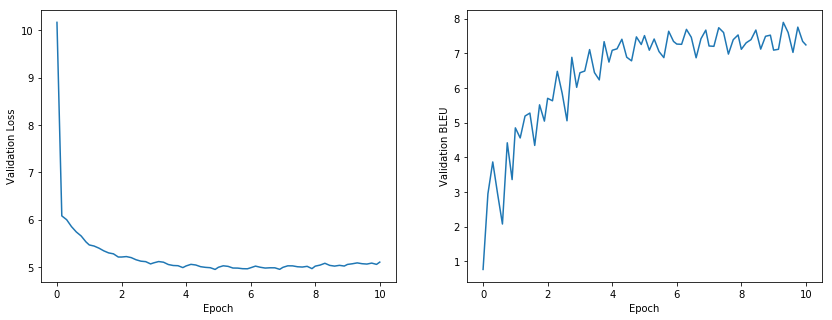

In [11]:
plot_single_learning_curve(experiment_results[0]['results'])

In [12]:
summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                       'total_params', 'trainable_params', 'dt_created']]

,model_name,best_val_loss,best_val_bleu,runtime,total_params,trainable_params,dt_created
0,zh-rnn-without-attn-2018-12-12 05:40:48,4.944853,7.889874,766.733748,69492144,51492144,2018-12-12 18:27:36


In [13]:
# reload model 
MODEL_NAME_TO_RELOAD = 'zh-rnn-without-attn-2018-12-12 05:40:48'
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME_TO_RELOAD), map_location=device)
model.load_state_dict(checkpoint)

In [14]:
# check performance on validation set 
val_loss, val_bleu, val_hyp_idxs, val_ref_idxs, val_source_idxs, val_hyp_tokens, val_ref_tokens, val_source_tokens,\
val_attn = evaluate(model=model, loader=loaders_full['dev'], 
                    src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Validation BLEU: {:.2f} | Validation Loss: {:.2f}".format(val_bleu, val_loss))

Validation BLEU: 0.77 | Validation Loss: 10.17


In [15]:
# evaluate on test set 
test_loss, test_bleu, test_hyp_idxs, test_ref_idxs, test_source_idxs, test_hyp_tokens, test_ref_tokens, test_source_tokens,\
test_attn = evaluate(model=model, loader=loaders_full['test'], 
                     src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Test BLEU: {:.2f} | Test Loss: {:.2f}".format(test_bleu, test_loss))

Test BLEU: 1.37 | Test Loss: 10.15
